# 0. Importing libraries

In [92]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("../Functions")
import warnings
warnings.filterwarnings(action = 'ignore')
import custom_functions
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import NearMiss
from joblib import dump, load
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.utils import to_categorical
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


plt.style.use('ggplot')
## Change title size of a plot
mpl.rcParams['axes.titlesize'] = 22
# Figure size
mpl.rc("figure", figsize = (15,7))
## Change label size(x and y) of a plot
mpl.rcParams['axes.labelsize'] = 18
## Change xticks size of a plot
mpl.rcParams['xtick.labelsize'] = 16
## Change yticks size of a plot
mpl.rcParams['ytick.labelsize'] = 16

# 0.1 Functions created

In [93]:
def process_data(df):
    
    # Empty dataframe
    new_df = pd.DataFrame()

    # Needed features
    features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays']
    features.extend(df.columns.values[17:])
    
    # storing selected columns in new dataframe
    for feat in features:
        new_df[feat] = df[feat]
    
    # Returning new dataframe
    return new_df


def classwise_accuracy(y_true, y_pred, flag = True):
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Normalizing the entries in the matrix
    cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    # Diagonal entries represent the accuracies of each class
    print("Class 0 Accuracy : ", cm.diagonal()[0])
    print("Class 1 Accuracy : ", cm.diagonal()[1])
    
    if flag:
        print("\n#############################################\n")
        

def custom_score_function(true, pred):
    
    # Confusion matrix
    cm = confusion_matrix(true, pred)

    # Normalizing the entries in the matrix
    cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    # Diagonal entries represent the accuracies of each class
    zero = cm.diagonal()[0]
    one = cm.diagonal()[1]
    
    # Returning the absolute difference
    return abs(zero - one)

# 1. Loading data

In [94]:
# loading csv file as a dataframe
data = pd.read_csv("DATA/bank-full.csv", sep = ";")

# 2. Data exploring

In [95]:
# Number of observations and variables
data.shape

(45211, 17)

In [96]:
# List of variables
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

## What variables represent?

### Bank Client Data

1 - age (**numeric**)

2 - job : type of job (**categorical**: "admin.", "unknown", "unemployed", "management", "housemaid", "entrepreneur", "student",
                        "blue-collar", "self-employed", "retired", "technician", "services") 

3 - marital : marital status (**categorical**: "married", "divorced", "single"; note: "divorced" means divorced or widowed)

4 - education (**categorical**: "unknown", "secondary", "primary", "tertiary")

5 - default: has credit in default? (**binary**: "yes", "no")

6 - balance: average yearly balance, in euros (**numeric**) 

7 - housing: has housing loan? (**binary**: "yes", "no")

8 - loan: has personal loan? (**binary**: "yes", "no")

### Related with the last contact of the current campaign:

9 - contact: contact communication type (**categorical**: "unknown", "telephone", "cellular") 

10 - day: last contact day of the month (**numeric**)

11 - month: last contact month of year (**categorical**: "jan", "feb", "mar", ..., "nov", "dec")

12 - duration: last contact duration, in seconds (**numeric**)

### other attributes:

13 - campaign: number of contacts performed during this campaign and for this client (**numeric**, includes last contact)

14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (**numeric**, -1 means client
was not previously contacted)

15 - previous: number of contacts performed before this campaign and for this client (**numeric**)

16 - poutcome: outcome of the previous marketing campaign (**categorical**: "unknown", "other", "failure", "success")

### Output variable (desired target):
17 - y - has the client subscribed a term deposit? (**binary**: "yes", "no")

In [97]:
# Information about the dataframe
# null_counts = true, will not count rows which have missing values in it.
data.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [98]:
# Checking for missing values
data.isna().all()

age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
y            False
dtype: bool

There are no missing values in any variables as mentioned by the data owner now I can carry out initial exploration using visualization after splitting data into 3 groups(training, validation and testing). 

### Some data preprocessing

In [99]:
# Dummy variables for nominal columns
dummy_cols = pd.get_dummies(data.loc[:, ['job', 'marital', 'education', 'month', 'poutcome', 'contact']], drop_first = True)

# Label encoding for binary variables
label_en = LabelEncoder()

# Empty dataframe
encoded_cols = pd.DataFrame()

# Adding encoded columns
encoded_cols['default_code'] = label_en.fit_transform(data['default'])
encoded_cols['loan_code'] = label_en.fit_transform(data['loan'])
encoded_cols['housing_code'] = label_en.fit_transform(data['housing'])
encoded_cols['y_code'] = label_en.fit_transform(data['y'])

# Creating new dataframe
data_new = data.copy()
data_new = data_new.join(dummy_cols)
data_new = data_new.join(encoded_cols)

### Splitting the data

In [100]:
shuffled_data = shuffle(data_new, random_state = 73).reset_index(drop = True)

# Splitting the dataframe in train, validate and test
## Reference - https://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.split.html
train_df, validate_df, test_df = np.split(
                                          shuffled_data.sample(frac = 1), 
                                          [ int( 0.8 * len(shuffled_data) ), int( 0.9 * len(shuffled_data) ) ] 
                                         )

### Storing the data in .CSV files

In [101]:
train_df.to_csv("DATA/train.csv", sep = "\t", index = False)
validate_df.to_csv("DATA/validate.csv", sep = "\t", index = False)
test_df.to_csv("DATA/test.csv", sep = "\t", index = False)

### Loading the data

In [102]:
train_df = pd.read_csv("DATA/train.csv", sep = "\t")
validate_df = pd.read_csv("DATA/validate.csv", sep = "\t")
test_df = pd.read_csv("DATA/test.csv", sep = "\t")

In [103]:
print("Training dataset :", train_df.shape)
print("Validation dataset :", validate_df.shape)
print("Testing dataset :", test_df.shape)

Training dataset : (36168, 53)
Validation dataset : (4521, 53)
Testing dataset : (4522, 53)


In [105]:
train_df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_married', 'marital_single',
       'education_secondary', 'education_tertiary', 'education_unknown',
       'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'poutcome_other', 'poutcome_success', 'poutcome_unknown',
       'contact_telephone', 'contact_unknown', 'default_code', 'loan_code',
       'housing_code', 'y_code'],
      dtype='object')

## Data Summaries and Visualizations

### age

In [106]:
train_df["age"].describe()

count    36168.000000
mean        40.964748
std         10.621709
min         18.000000
25%         33.000000
50%         39.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64

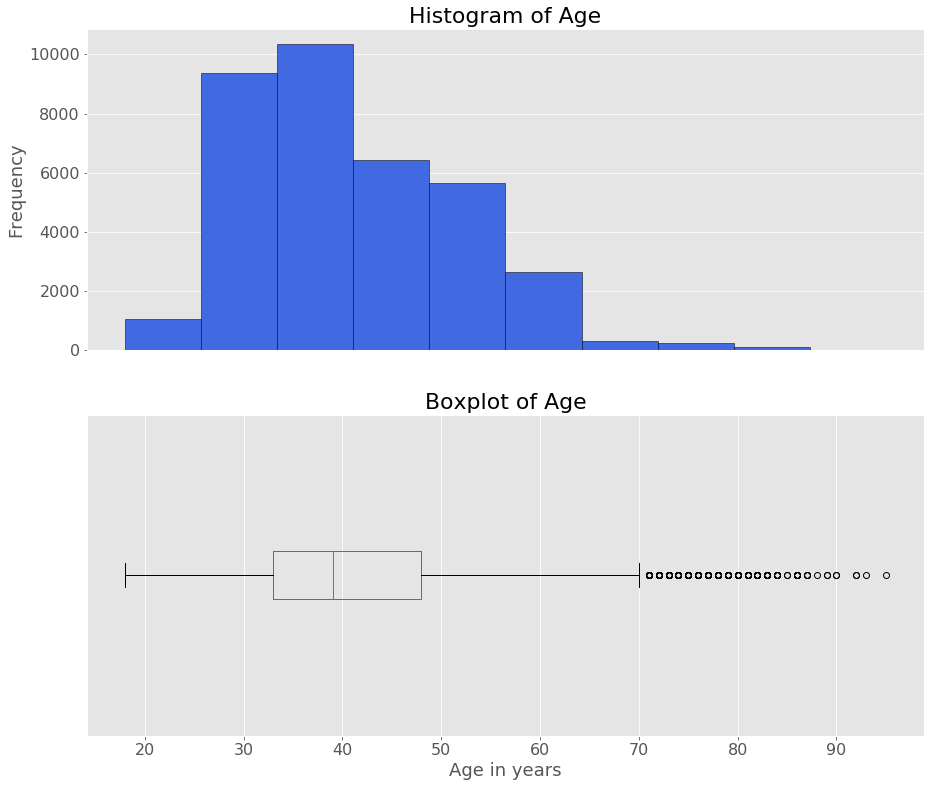

In [107]:
%autoreload 2
custom_functions.create_histogram_plus_boxplot(train_df["age"], "Age", color = "royalblue", ylabel = "Frequency", 
                                               xlabel = "Age in years" , size = (15,13))

In [108]:
print("Number of outliers :", train_df[train_df["age"] > 70].shape[0])

Number of outliers : 394


Distribution is right skewed which makes sense as there should be less participation from old people in such term deposit plan that's why there are outliers in the data. Observations where age is greater than 70 years(BY looking at the boxplot right hand whisker) are outliers, which is reasonable amount.

### job

In [109]:
# Frequency
job_count_series = train_df["job"].value_counts()
job_count_series

blue-collar      7798
management       7563
technician       6105
admin.           4109
services         3308
retired          1815
self-employed    1264
entrepreneur     1191
unemployed       1034
housemaid        1003
student           749
unknown           229
Name: job, dtype: int64

In [110]:
# Percentage
job_count_series/train_df.shape[0] * 100

blue-collar      21.560495
management       20.910750
technician       16.879562
admin.           11.360871
services          9.146207
retired           5.018248
self-employed     3.494802
entrepreneur      3.292966
unemployed        2.858881
housemaid         2.773170
student           2.070891
unknown           0.633156
Name: job, dtype: float64

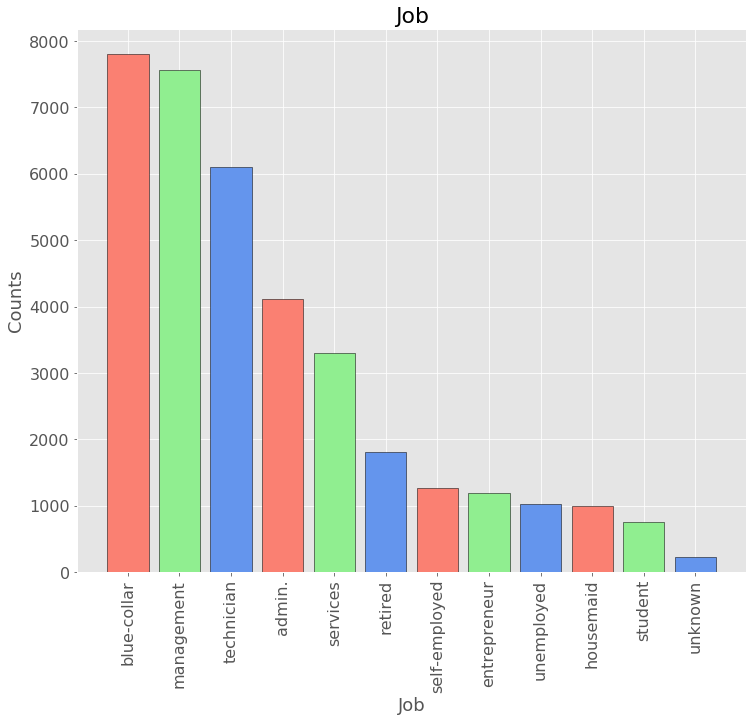

In [111]:
# Barplot
%autoreload 2
custom_functions.barplot(job_count_series, "Job", "Counts", "Job", 
                         color = ("salmon", "lightgreen", "cornflowerblue",) * 4, labels = job_count_series.index, 
                         xrotation = 90)

Most of the customers have blue-collar jobs or jobs in management. Very few Housemaid and stundents have bank accounts.

### marital

In [112]:
# Frequency
marital_count_series = train_df["marital"].value_counts()
marital_count_series

married     21788
single      10182
divorced     4198
Name: marital, dtype: int64

In [113]:
# Percentage
marital_count_series/train_df.shape[0] * 100

married     60.241097
single      28.151958
divorced    11.606945
Name: marital, dtype: float64

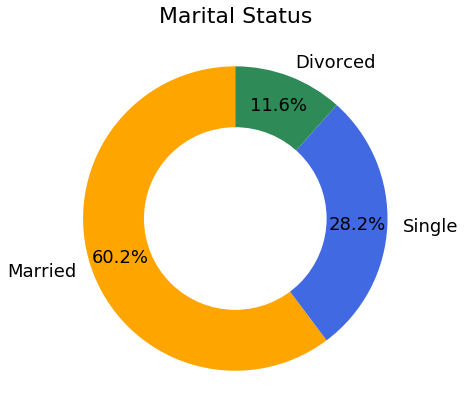

In [114]:
# Donut Chart
plt.pie(marital_count_series, colors = ["orange", "royalblue", "seagreen"], labels = ["Married", "Single", "Divorced"], 
        autopct = '%1.1f%%', startangle = 90, pctdistance = 0.80, textprops = {"fontsize" : 18})
plt.gca().add_artist(plt.Circle((0, 0), 0.60, fc = 'white'));
plt.title("Marital Status")
plt.show()

Most of the account holders are married.

### education

In [115]:
# Frequency
edu_count_series = train_df["education"].value_counts()
edu_count_series

secondary    18605
tertiary     10618
primary       5476
unknown       1469
Name: education, dtype: int64

In [116]:
# Percentage
edu_count_series/train_df.shape[0] * 100

secondary    51.440500
tertiary     29.357443
primary      15.140456
unknown       4.061601
Name: education, dtype: float64

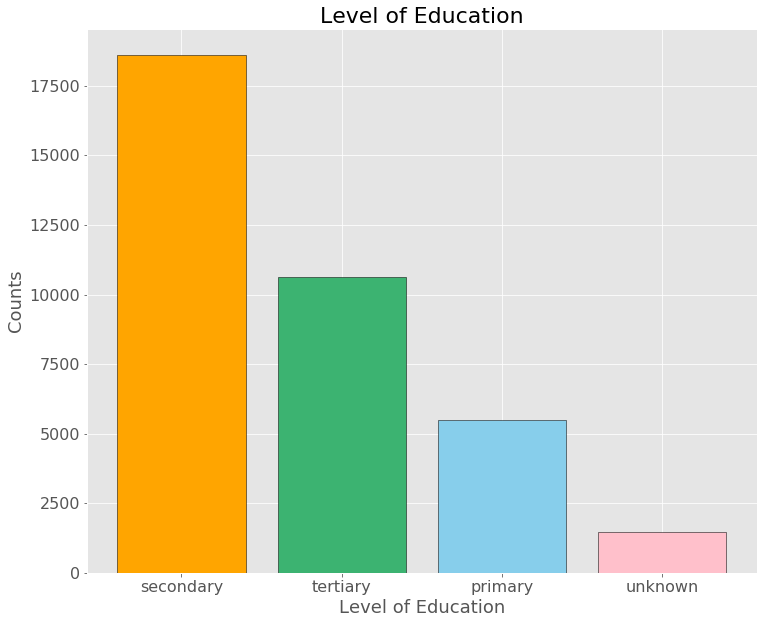

In [117]:
# Barplot
%autoreload 2
custom_functions.barplot(edu_count_series, "Level of Education", "Counts", "Level of Education", 
                         color = ("orange", "mediumseagreen", "skyblue", "pink"), labels = edu_count_series.index)

Most of the account holders have secondary educations followed by customers who have tertiary education.

### default

In [118]:
# Frequency
default_count_series = train_df["default"].value_counts()
default_count_series

no     35505
yes      663
Name: default, dtype: int64

In [119]:
# Percentage
default_count_series/train_df.shape[0] * 100

no     98.166888
yes     1.833112
Name: default, dtype: float64

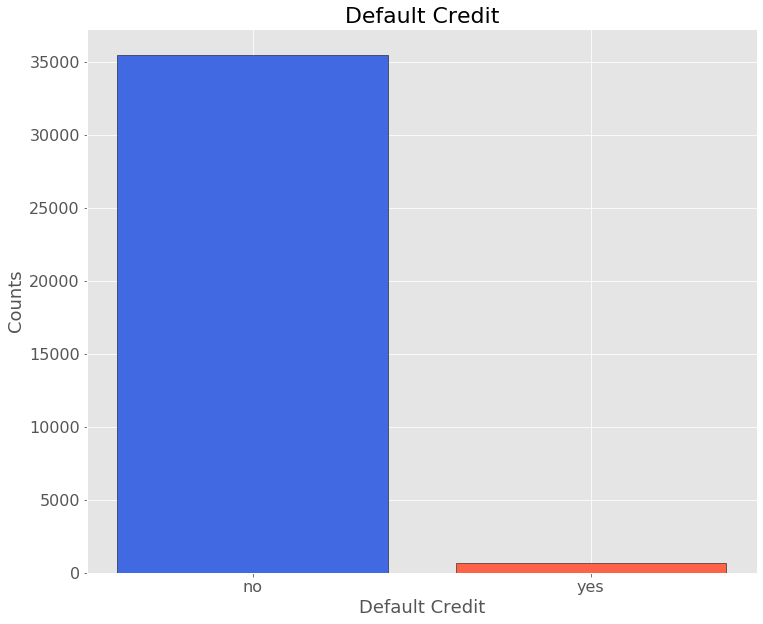

In [120]:
# Barplot
%autoreload 2
custom_functions.barplot(default_count_series, "Default Credit", "Counts", "Default Credit", color = ("royalblue", "tomato"), 
                         labels = default_count_series.index)

Nearly 1.8% of the account holders were failed to repay a debt back to the bank.

### balance

In [121]:
train_df["balance"].describe()

count     36168.000000
mean       1347.880060
std        2973.296172
min       -8019.000000
25%          71.000000
50%         448.000000
75%        1423.000000
max      102127.000000
Name: balance, dtype: float64

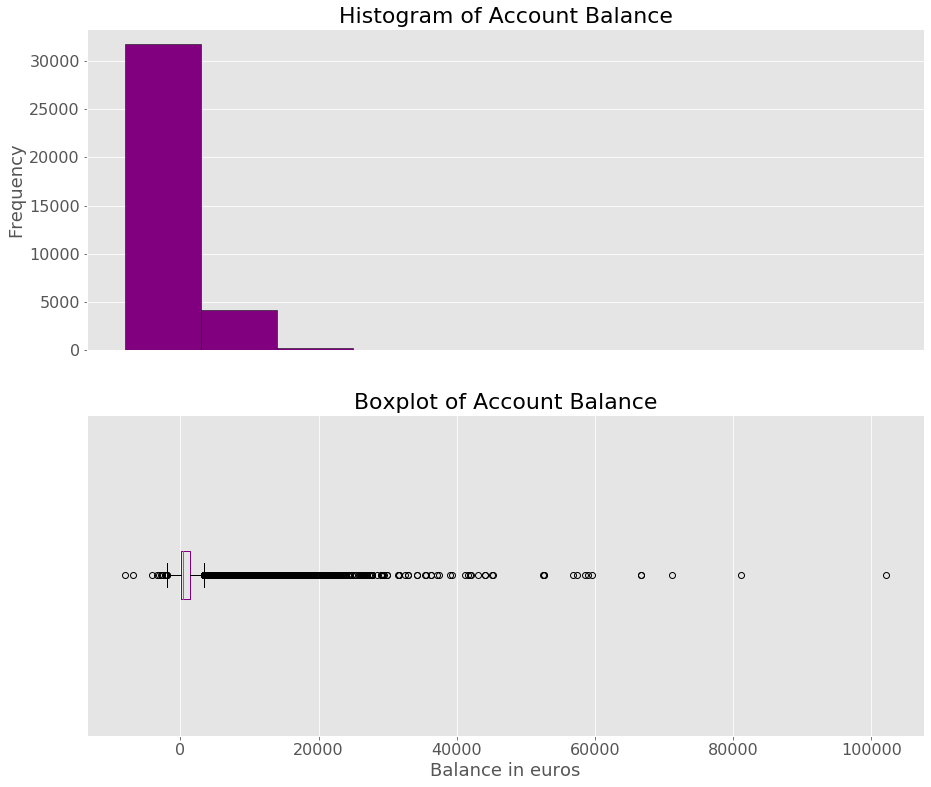

In [122]:
%autoreload 2
custom_functions.create_histogram_plus_boxplot(train_df["balance"], "Account Balance", color = "purple", 
                                               ylabel = "Frequency", xlabel = "Balance in euros" , size = (15, 13))

As we can see there are many outliers in the balance variable, by looking at the boxplot above we can say that amount greater than 40k can be ruled as extreme. Let's have a look at those account holders.

In [123]:
train_df[train_df["balance"] > 40000].iloc[:,:17]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
38,60,retired,married,primary,no,71188,no,no,cellular,6,oct,205,1,-1,0,unknown,no
2434,56,blue-collar,married,secondary,no,58932,no,no,telephone,7,jul,339,2,-1,0,unknown,no
3828,55,management,single,tertiary,no,43074,yes,no,cellular,25,aug,92,6,-1,0,unknown,no
5172,59,housemaid,divorced,secondary,no,45141,no,no,unknown,6,jun,42,1,-1,0,unknown,no
6934,55,entrepreneur,married,tertiary,no,41923,no,no,cellular,6,aug,69,3,-1,0,unknown,no
7865,44,admin.,married,secondary,no,58544,yes,no,unknown,7,may,144,2,-1,0,unknown,no
10616,43,admin.,single,secondary,no,56831,no,no,unknown,15,may,243,1,-1,0,unknown,no
10856,59,retired,married,tertiary,no,41242,no,no,cellular,21,nov,161,1,-1,0,unknown,no
10883,61,self-employed,divorced,tertiary,no,52587,no,no,cellular,15,feb,394,3,189,1,success,yes
11862,56,management,divorced,tertiary,no,66721,no,no,cellular,8,aug,442,2,-1,0,unknown,no


There are many outliers in account balance variable. Most extremes(approx. 20) outliers are where the account balance is greater than 40,000 EUROS. All other columns seem valid so I will keep the outliers as they are because they represent the nature of the distribution. Most of the high balance account holders are in management jobs or retired and had tertiary education. Most of the account holders are married as well as they dont have default credit(given high balance). Most of them have neither have personal or home loan(given high balance). 

In [124]:
negative_bal = train_df[train_df["balance"] < 0].copy()
negative_bal.iloc[:,:17].head(20)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
9,48,management,married,tertiary,yes,-13,yes,no,cellular,15,may,20,6,291,2,other,no
12,54,blue-collar,single,primary,no,-119,yes,no,cellular,13,may,261,1,-1,0,unknown,no
19,32,self-employed,single,tertiary,no,-359,yes,no,cellular,9,feb,122,3,-1,0,unknown,no
50,44,blue-collar,married,secondary,no,-674,yes,no,unknown,5,may,257,1,-1,0,unknown,no
51,41,management,married,tertiary,no,-456,no,no,cellular,14,apr,427,4,144,1,failure,no
52,27,services,married,unknown,no,-209,yes,yes,cellular,29,jan,128,1,-1,0,unknown,no
74,59,management,divorced,tertiary,yes,-23,yes,no,telephone,7,may,287,2,-1,0,unknown,no
104,37,technician,married,secondary,yes,-143,yes,no,cellular,4,feb,95,1,-1,0,unknown,no
114,44,services,married,secondary,no,-395,yes,no,cellular,5,may,894,1,-1,0,unknown,yes
115,40,technician,married,secondary,no,-496,no,no,telephone,28,jul,22,2,-1,0,unknown,no


In [125]:
## AGE
negative_bal["age"].describe()

count    3048.000000
mean       39.583333
std         9.116841
min        20.000000
25%        32.000000
50%        38.000000
75%        46.000000
max        63.000000
Name: age, dtype: float64

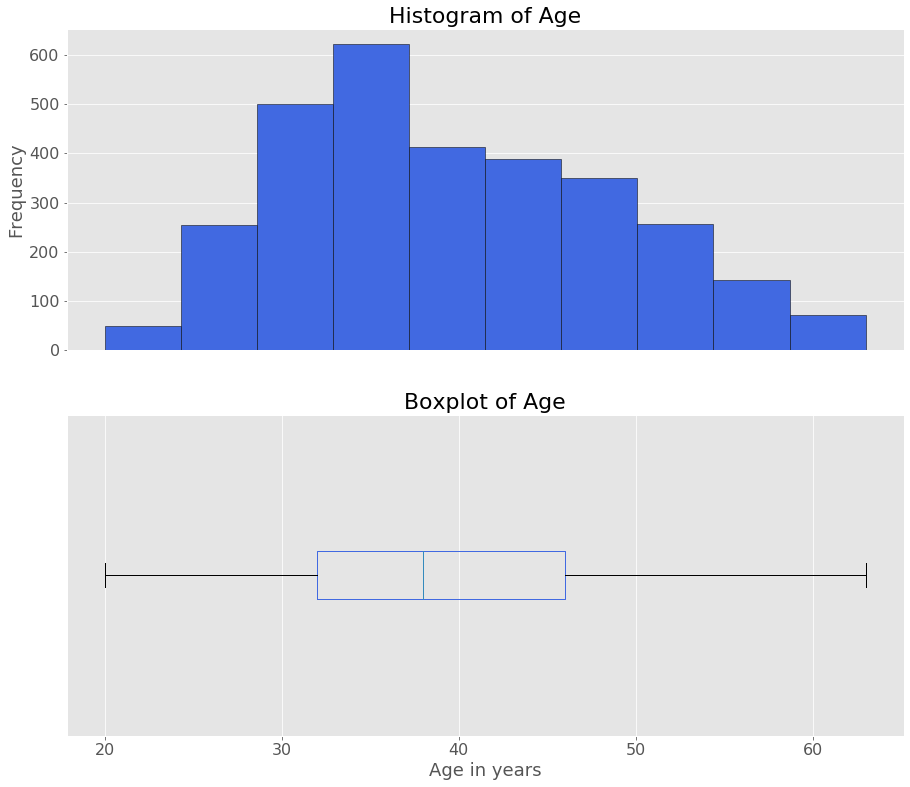

In [126]:
%autoreload 2
custom_functions.create_histogram_plus_boxplot(negative_bal["age"], "Age", color = "royalblue", ylabel = "Frequency", 
                                               xlabel = "Age in years" , size = (15,13))

Most of the account holders with the negative balance are aged between 32 and 46\[Working adults\]. 

In [127]:
negative_bal["job"].value_counts()/len(negative_bal) * 100

blue-collar      29.199475
technician       17.650919
management       15.190289
admin.           13.221785
services         12.762467
retired           3.379265
entrepreneur      2.887139
self-employed     2.230971
unemployed        1.870079
housemaid         1.148294
student           0.328084
unknown           0.131234
Name: job, dtype: float64

As we can see that most of the account holders(more than 25%) have blue collar job, which explains the negative balance as these people work at the bottom of the chain and enagaged with manual labor work. 

In [128]:
negative_bal["education"].value_counts()/len(negative_bal) * 100

secondary    61.417323
tertiary     19.094488
primary      16.437008
unknown       3.051181
Name: education, dtype: float64

compare to people with account having high balance, most of these account holders have fininshed secondary education(high school), which also explain the fact that they are engaged in the manual labour work and not high end job like management.

In [129]:
print("Neg balance Housing Loan : \n")
print(negative_bal["housing"].value_counts()/len(negative_bal) * 100)

Neg balance Housing Loan : 

yes    72.670604
no     27.329396
Name: housing, dtype: float64


By looking at the data, as we can see that most of the people with negative balance have housing loan.

### housing

In [130]:
# Frequency
housing_count_series = train_df["housing"].value_counts()
housing_count_series

yes    20086
no     16082
Name: housing, dtype: int64

In [131]:
# Percentage
housing_count_series/train_df.shape[0] * 100

yes    55.53528
no     44.46472
Name: housing, dtype: float64

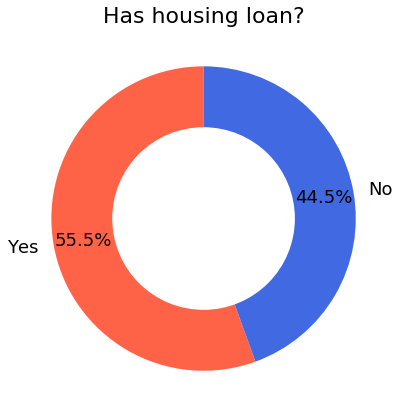

In [132]:
# Donut Chart
plt.pie(housing_count_series, colors = ["tomato", "royalblue"], labels = ["Yes", "No"], 
        autopct = '%1.1f%%', startangle = 90, pctdistance = 0.80, textprops = {"fontsize" : 18})
plt.gca().add_artist(plt.Circle((0, 0), 0.60, fc = 'white'));
plt.title("Has housing loan?")
plt.show()

Majority of the customers have a housing loan.

### loan

In [133]:
# Frequency
loan_count_series = train_df["loan"].value_counts()
loan_count_series

no     30384
yes     5784
Name: loan, dtype: int64

In [134]:
# Percentage
loan_count_series/train_df.shape[0] * 100

no     84.007963
yes    15.992037
Name: loan, dtype: float64

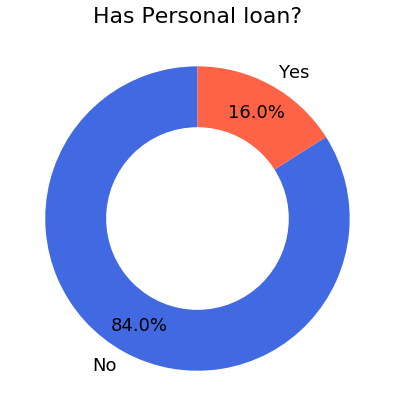

In [135]:
# Donut Chart
plt.pie(loan_count_series, colors = ["royalblue", "tomato"], labels = ["No", "Yes"], 
        autopct = '%1.1f%%', startangle = 90, pctdistance = 0.80, textprops = {"fontsize" : 18})
plt.gca().add_artist(plt.Circle((0, 0), 0.60, fc = 'white'));
plt.title("Has Personal loan?")
plt.show()

Majority of the account holders does not have a personal loan.

### contact

In [136]:
# Frequency
contact_count_series = train_df["contact"].value_counts()
contact_count_series

cellular     23432
unknown      10405
telephone     2331
Name: contact, dtype: int64

In [137]:
# Percentage
contact_count_series/train_df.shape[0] * 100

cellular     64.786552
unknown      28.768525
telephone     6.444924
Name: contact, dtype: float64

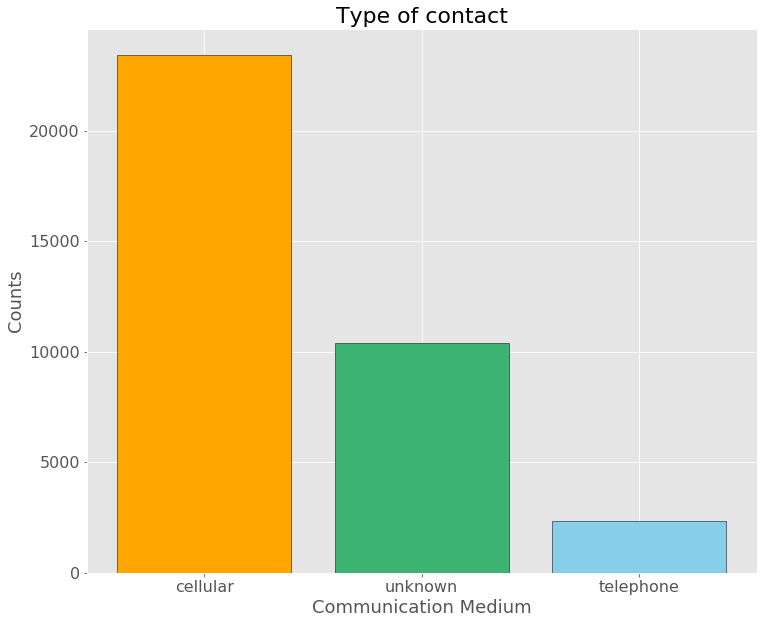

In [138]:
# Barplot
%autoreload 2
custom_functions.barplot(contact_count_series, "Communication Medium", "Counts", "Type of contact", 
                         color = ("orange", "mediumseagreen", "skyblue"), labels = contact_count_series.index)

Most of the customers were contacted on their cellular regarding the term deposit which makes sense as time when data was collected mobile phones were more prominient and everyone had one with them. 

In [139]:
print("Median age of the customers who were contacted using cellular :", 
      train_df[train_df["contact"] == "cellular"]["age"].median())

Median age of the customers who were contacted using cellular : 38.0


In [140]:
print("Median age of the customers who were contacted using telephone :", 
      train_df[train_df["contact"] == "telephone"]["age"].median())

Median age of the customers who were contacted using telephone : 47.0


The above calculation and graphs reflect that cellular was more popular among the younger people compared to people using telephone. \[Old People generally use telephones\]

### day

In [141]:
# Frequency
day_count_series = train_df["day"].value_counts()
day_count_series

20    2215
18    1822
21    1631
17    1541
5     1525
6     1522
8     1469
14    1462
28    1441
7     1434
19    1398
29    1392
15    1385
12    1315
9     1281
30    1274
13    1269
11    1199
4     1150
16    1123
2     1044
27     875
3      839
26     830
23     769
22     736
25     665
31     513
10     411
24     371
1      267
Name: day, dtype: int64

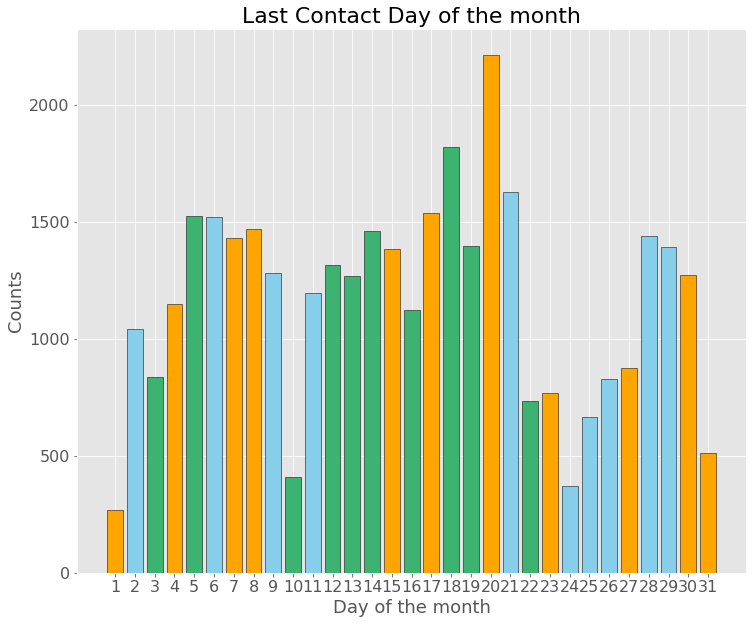

In [142]:
# Barplot
%autoreload 2
custom_functions.barplot(day_count_series, "Day of the month", "Counts", "Last Contact Day of the month", 
                         color = ("orange", "mediumseagreen", "skyblue",) * 10, labels = day_count_series.index)

Contacts regarding the term deposits were generally made in the middle of the months The Least mean amount of the calls were made in the last week of the months.

### month

In [143]:
# Frequency
month_count_series = train_df["month"].value_counts()
print(month_count_series)
month_count_series = month_count_series[['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct','nov', 'dec']]

may    10996
jul     5537
aug     5038
jun     4262
nov     3167
apr     2347
feb     2140
jan     1116
oct      570
sep      463
mar      371
dec      161
Name: month, dtype: int64


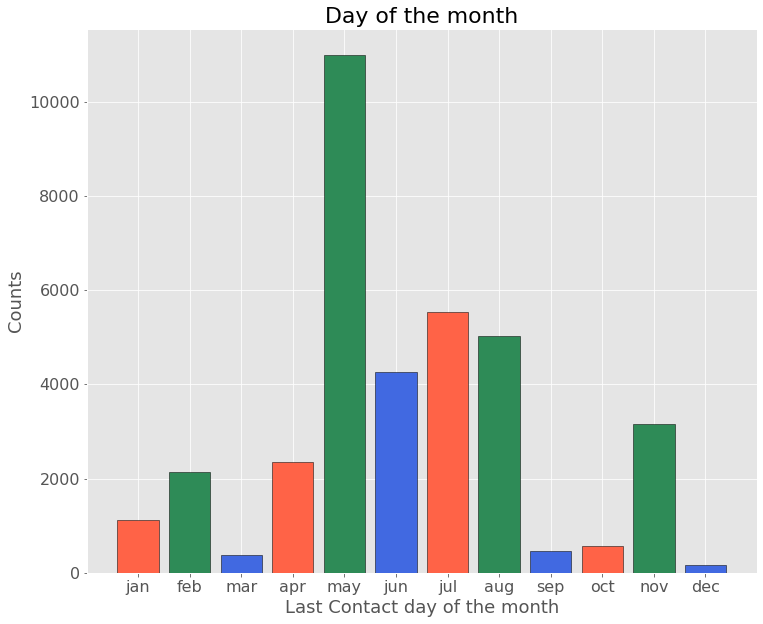

In [144]:
# Barplot
%autoreload 2
custom_functions.barplot(month_count_series, "Last Contact day of the month", "Counts", "Day of the month", 
                         color = ("tomato", "seagreen", "royalblue",) * 10, labels = month_count_series.index)

Most of the contacts were made in the month may. Majority of the contacts were made in the middle of the year. December has the least number of the contacts that can be explained by the festive season(employees not working/customers don't have time to talk to the bank employees/last month of the fiscal year)

### duration

In [145]:
train_df["duration"].describe()

count    36168.000000
mean       259.257797
std        257.863214
min          0.000000
25%        103.000000
50%        181.000000
75%        320.000000
max       4918.000000
Name: duration, dtype: float64

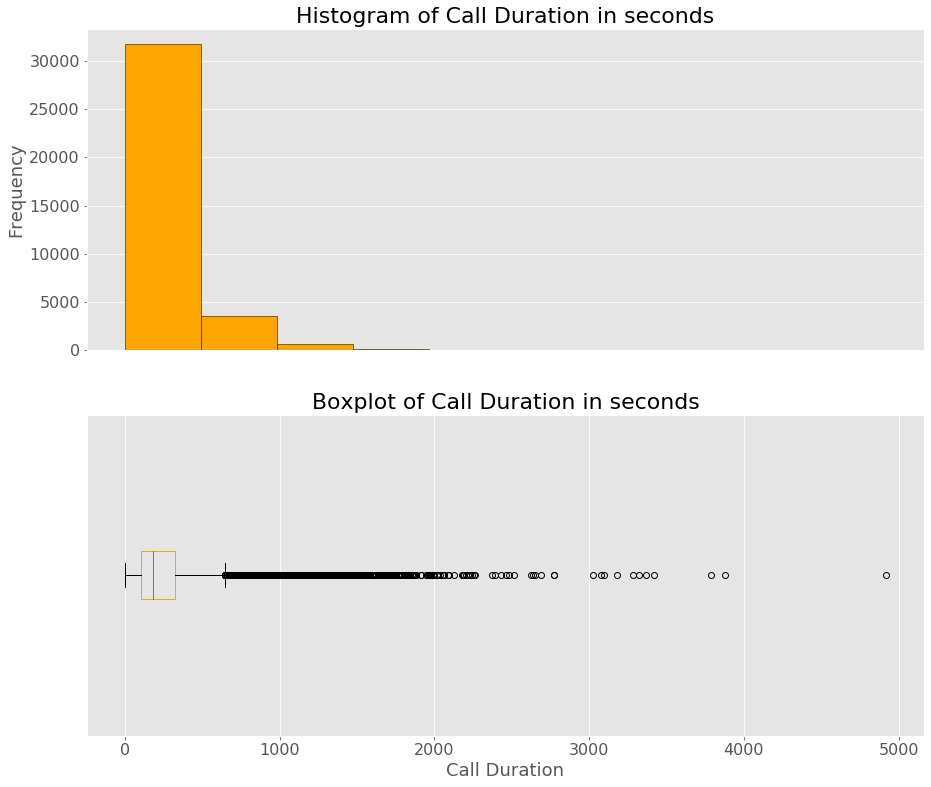

In [146]:
%autoreload 2
custom_functions.create_histogram_plus_boxplot(train_df["duration"], "Call Duration in seconds", color = "orange", 
                                               ylabel = "Frequency", xlabel = "Call Duration" , size = (15, 13))

Most common duration for the call is 3 minutes(180 seconds). There are many outliers out of which duration > 2500 seconds are extreme ones. Maximum duration for the call is 63 minutes(3785 seconds) which is quite long.

### campaign

In [147]:
train_df["campaign"].describe()

count    36168.000000
mean         2.764433
std          3.100339
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         63.000000
Name: campaign, dtype: float64

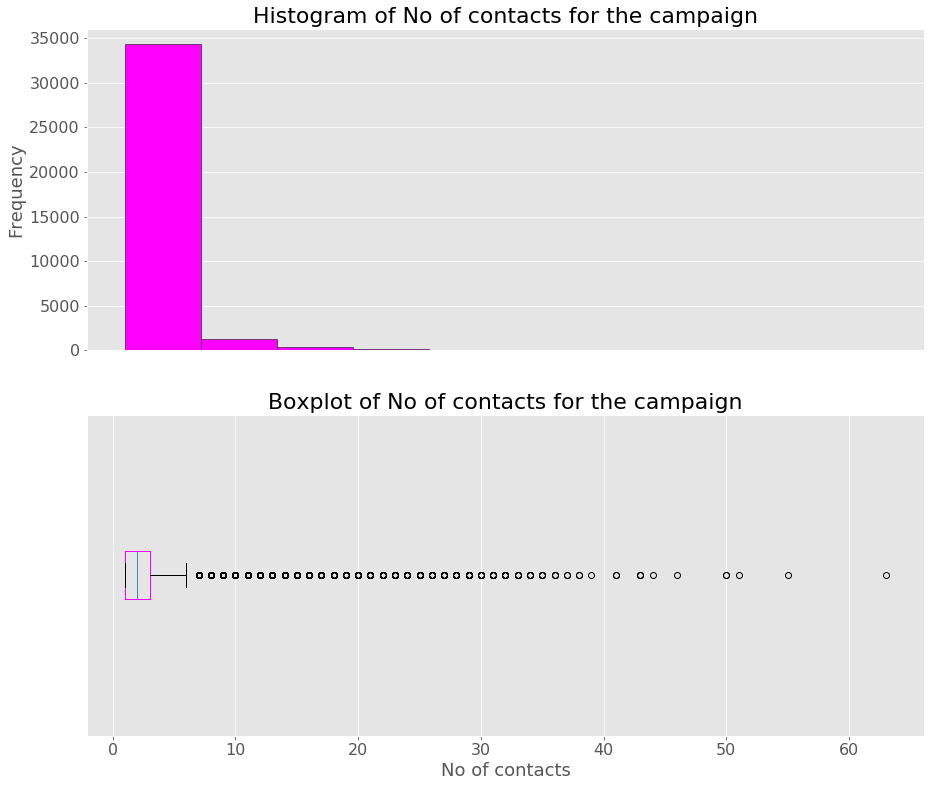

In [148]:
%autoreload 2
custom_functions.create_histogram_plus_boxplot(train_df["campaign"], "No of contacts for the campaign", color = "magenta", 
                                               ylabel = "Frequency", xlabel = "No of contacts" , size = (15, 13))

On average account holders were contacted 2 times. There aremany outliers out of which no of the times contacts are greater 40 are extreme. The highest no of contact is 63 which is quite large and unusual.

### pdays

In [149]:
not_contacted_count = train_df[train_df["pdays"] == -1].shape[0]
contacted_count = train_df.shape[0] - not_contacted_count

contacted = train_df[train_df["pdays"] != -1]

print("Previously Contacted :", contacted_count)
print("Previously Not Contacted :", not_contacted_count)

Previously Contacted : 6600
Previously Not Contacted : 29568


In [150]:
contacted["pdays"].describe()

count    6600.000000
mean      224.475303
std       114.598507
min         1.000000
25%       133.000000
50%       195.000000
75%       326.000000
max       871.000000
Name: pdays, dtype: float64

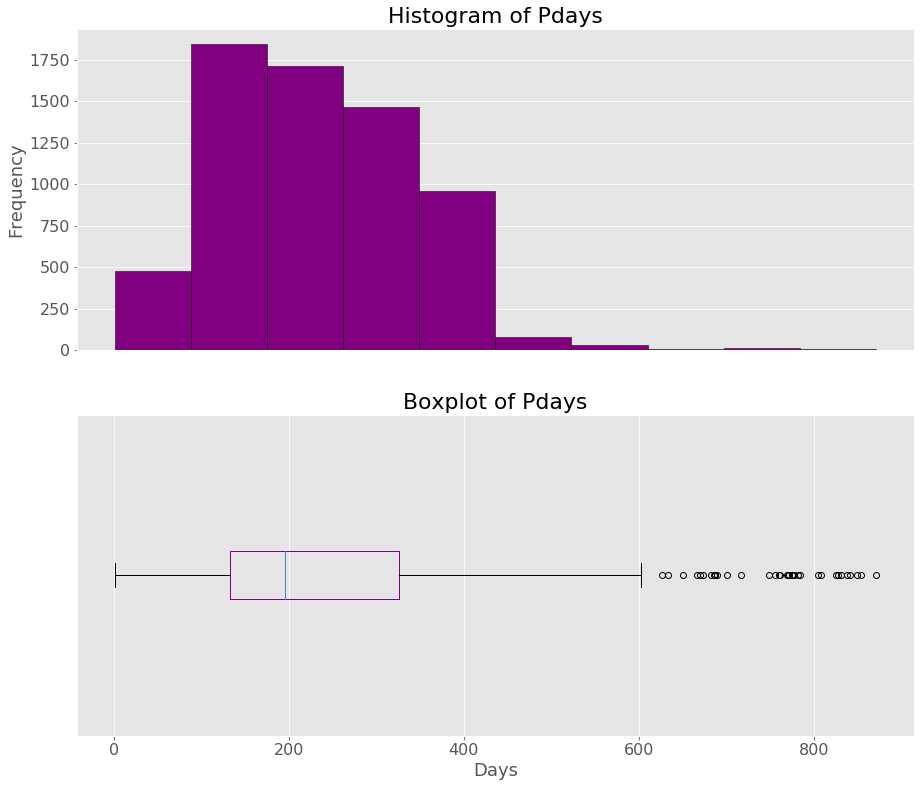

In [151]:
%autoreload 2
custom_functions.create_histogram_plus_boxplot(contacted["pdays"], "Pdays", color = "purple", 
                                               ylabel = "Frequency", xlabel = "Days" , size = (15, 13))

Average number of days that passed by after the client was last contacted from a previous campaign is 225 days. There are few outliers but none of them are too extreme.

### previous

In [152]:
train_df["previous"].describe()

count    36168.000000
mean         0.583803
std          2.401659
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        275.000000
Name: previous, dtype: float64

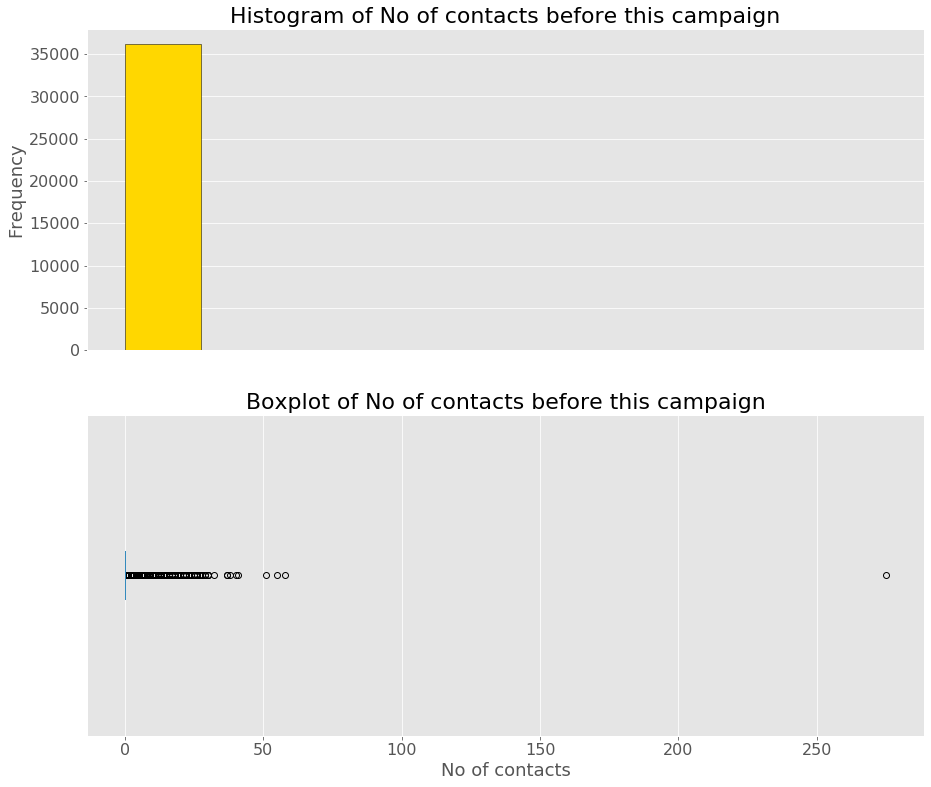

In [153]:
%autoreload 2
custom_functions.create_histogram_plus_boxplot(train_df["previous"], "No of contacts before this campaign", color = "gold", 
                                               ylabel = "Frequency", xlabel = "No of contacts" , size = (15, 13))

There is one extreme outlier where number of contacts performed before this campaign is 275. I will remove this observation from the data.

In [154]:
train_df = train_df[train_df["previous"] < 275]

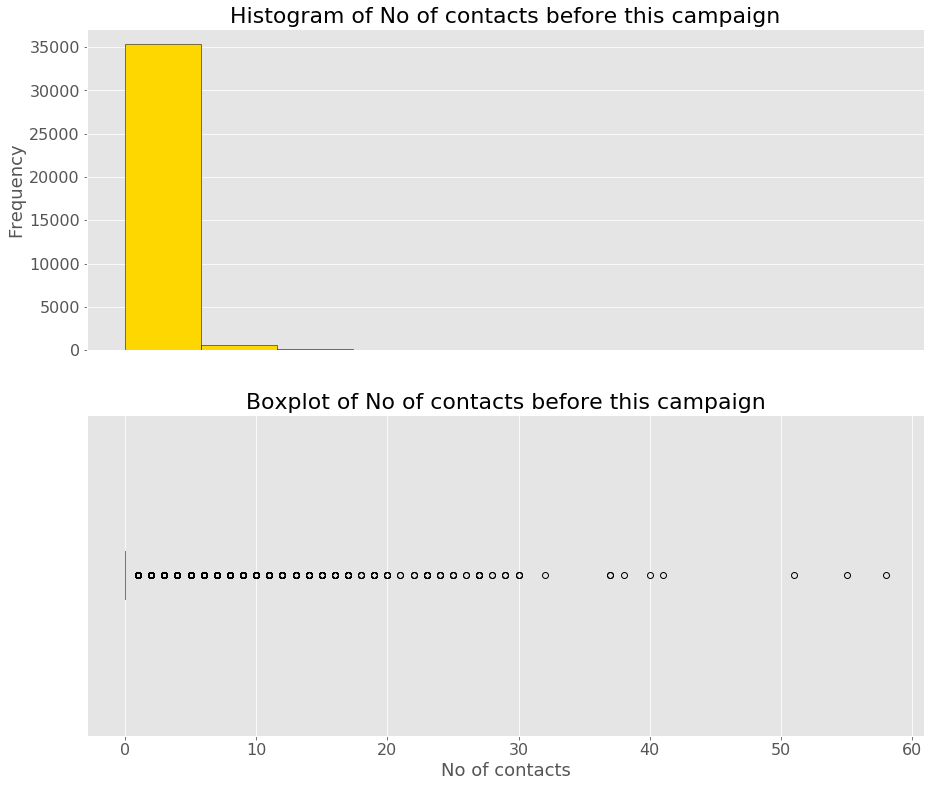

In [155]:
%autoreload 2
custom_functions.create_histogram_plus_boxplot(train_df["previous"], "No of contacts before this campaign", color = "gold", 
                                               ylabel = "Frequency", xlabel = "No of contacts" , size = (15, 13))

In [156]:
not_contacted_count = train_df[train_df["previous"] == 0].shape[0]
contacted_count = train_df.shape[0] - not_contacted_count

contacted = train_df[train_df["previous"] != 0]

print("Previously Contacted :", contacted_count)
print("Previously Not Contacted :", not_contacted_count)

Previously Contacted : 6599
Previously Not Contacted : 29568


In [157]:
contacted["previous"].describe()

count    6599.000000
mean        3.158054
std         3.471142
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        58.000000
Name: previous, dtype: float64

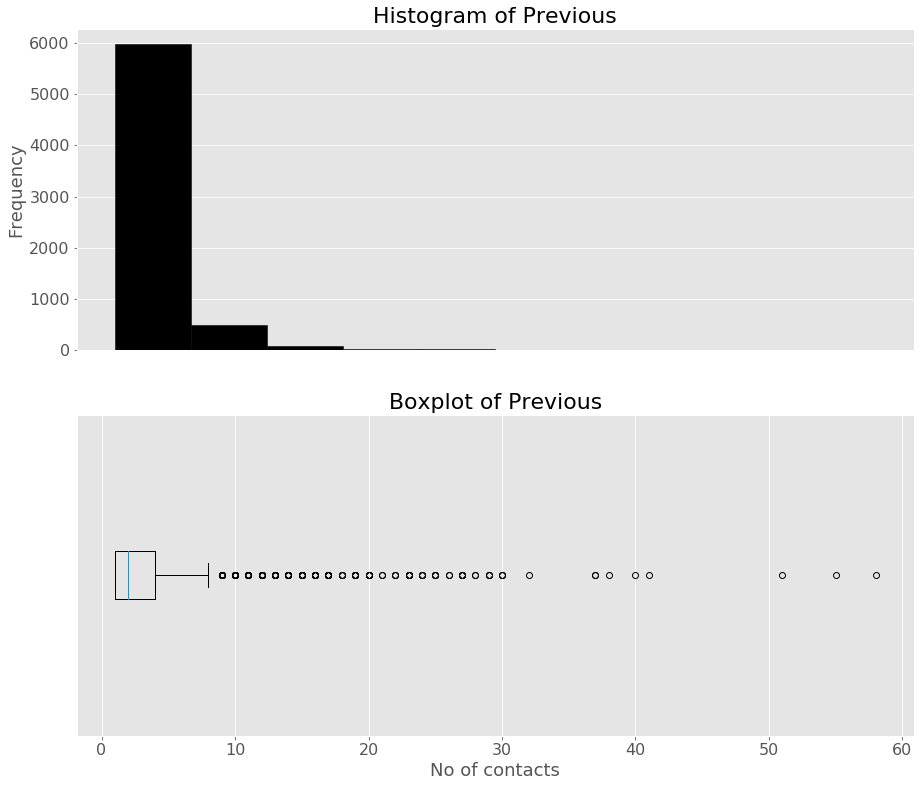

In [158]:
%autoreload 2
custom_functions.create_histogram_plus_boxplot(contacted["previous"], "Previous", color = "black", 
                                               ylabel = "Frequency", xlabel = "No of contacts" , size = (15, 13))

Average number of contacts made before this campaign is 3. There are few outliers few extreme ones where no of contact is greater than 50 but due to low in number I will keep them as it is.

### poutcome

In [159]:
# Frequency
poutcome_count_series = train_df["poutcome"].value_counts()
poutcome_count_series

unknown    29573
failure     3923
other       1468
success     1203
Name: poutcome, dtype: int64

In [160]:
# Percentage
poutcome_count_series/train_df.shape[0] * 100

unknown    81.767910
failure    10.846905
other       4.058949
success     3.326237
Name: poutcome, dtype: float64

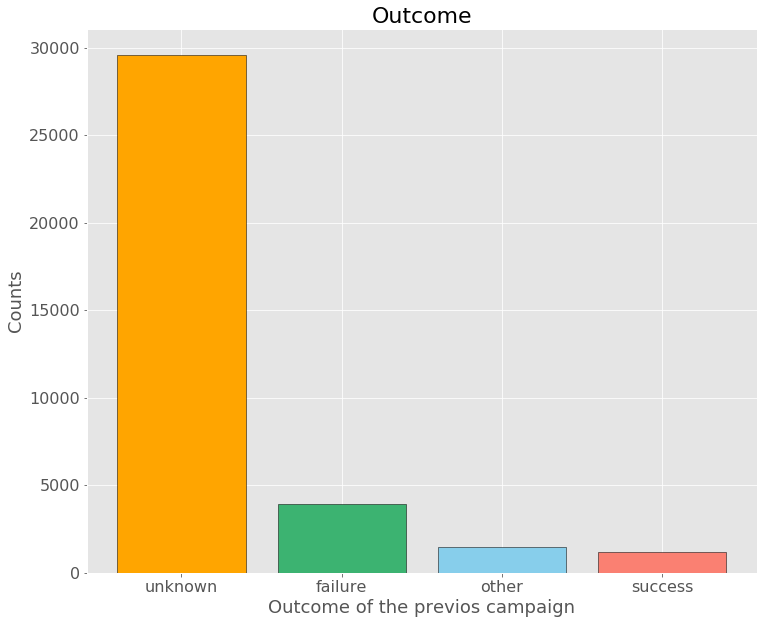

In [161]:
# Barplot
%autoreload 2
custom_functions.barplot(poutcome_count_series, "Outcome of the previos campaign", "Counts", "Outcome", 
                         color = ("orange", "mediumseagreen", "skyblue", "salmon"), labels = poutcome_count_series.index)

If we ignore the the observation where outcome is unknown and other, the success rate for the previous campaign is quite low(half as failure rate).

### y

In [162]:
# Frequency
y_count_series = train_df["y"].value_counts()
y_count_series

no     31879
yes     4288
Name: y, dtype: int64

In [163]:
# Percentage
y_count_series/train_df.shape[0] * 100

no     88.143888
yes    11.856112
Name: y, dtype: float64

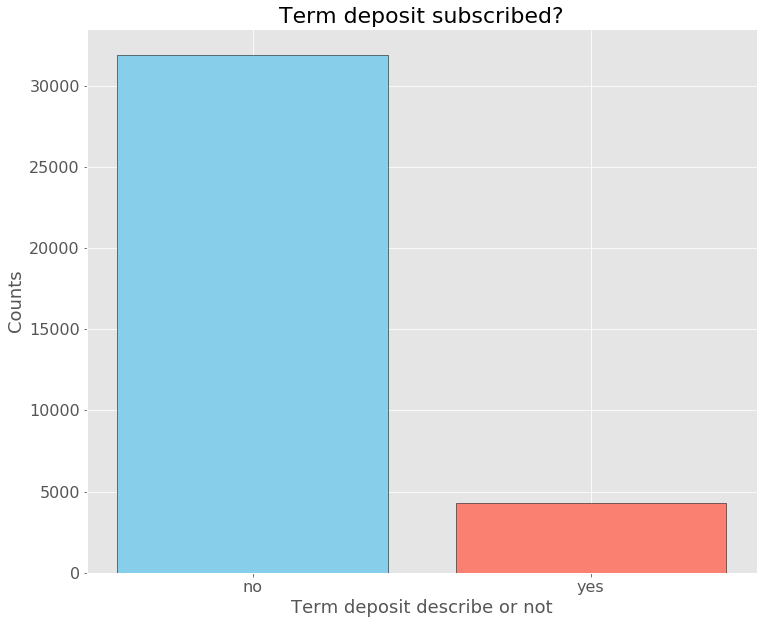

In [164]:
# Barplot
%autoreload 2
custom_functions.barplot(y_count_series, "Term deposit describe or not", "Counts", "Term deposit subscribed?", 
                         color = ("skyblue", "salmon"), labels = y_count_series.index)

There are only 12% of the clients subscribed to the terms which can be explained by the poor success rate of previous campaign outcome. As we can see that data is imbalanced in the terms of outcome variable.

## Data Preprocessing

In [165]:
new_train = process_data(train_df)
new_valid = process_data(validate_df)
new_test = process_data(test_df)

# Training data
X_train = new_train.iloc[:,:-1]
y_train = new_train.iloc[:, -1]

# Validation data
X_valid = new_valid.iloc[:,:-1]
y_valid = new_valid.iloc[:, -1]

# Test data
X_test = new_test.iloc[:,:-1]
y_test = new_test.iloc[:, -1]


print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_valid shape: ", X_valid.shape)
print("y_valid shape: ", y_valid.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (36167, 41)
y_train shape:  (36167,)
X_valid shape:  (4521, 41)
y_valid shape:  (4521,)
X_test shape:  (4522, 41)
y_test shape:  (4522,)


### Scaling

In [172]:
X_train.head()

,age,balance,day,duration,campaign,pdays,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,contact_telephone,contact_unknown,default_code,loan_code,housing_code
0,43,14144,21,504,1,-1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,36,1604,11,47,3,-1,0,0,0,1,...,0,0,0,0,1,0,1,0,0,1
2,48,505,7,113,2,-1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,45,1780,9,464,1,-1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
4,34,0,11,331,2,-1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


As we can see that all features are on different scale(footing), it is better to scale them so that variance of these features dont affect the models.

In [173]:
# Scaling the data
X_train.loc[:, ["age", "balance", "day", "duration", "campaign", "pdays"]] = preprocessing.scale(X_train.loc[:, ["age", "balance", "day", "duration", "campaign", "pdays"]])
X_valid.loc[:, ["age", "balance", "day", "duration", "campaign", "pdays"]] = preprocessing.scale(X_valid.loc[:, ["age", "balance", "day", "duration", "campaign", "pdays"]])
X_test.loc[:, ["age", "balance", "day", "duration", "campaign", "pdays"]] = preprocessing.scale(X_test.loc[:, ["age", "balance", "day", "duration", "campaign", "pdays"]])

### SMOTE Over Sampling

#### Problem

In [174]:
new_train["y_code"].value_counts()

0    31879
1     4288
Name: y_code, dtype: int64

As we can see that the data is imbalanced. The number of observations with y value 1 is way less compared to number of observation with y value 0. Such unbalanced dataset can cause models to learn well about frequently appearing y values but when it comes to less frequent category model is unable to learn. Consider following example.

In [175]:
# Let's run simple logistic regression for our imbalanced data set
# Init the model
log_model = LogisticRegression(random_state=79)

# Fitting the model
log_model.fit(X_train, y_train);

In [176]:
# Prediction labels for validation data
y_valid_pred = log_model.predict(X_valid)

# Checking the performance of the model
print("Overall Accuracy of the model : ", accuracy_score(y_valid, y_valid_pred))

Overall Accuracy of the model :  0.9006856890068569


As we can see that overall accuract is 90% which is good but let's look at class wise accuracy and see how well model did.

In [177]:
# Confusion matrix
cm = confusion_matrix(y_valid, y_valid_pred)

# Normalizing the entries in the matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Diagonal entries represent the accuracies of each class
print("Class 0 Accuracy : ", cm.diagonal()[0])
print("Class 1 Accuracy : ", cm.diagonal()[1])

Class 0 Accuracy :  0.9712301587301587
Class 1 Accuracy :  0.31901840490797545


As we can see that model got 98% accuracy for class 0 observations while on the other hand model is poorly performing for class 1 observations. Here our objective is to predict whether client subscribes to a loan or not model need to perform well on both classes especially for class 1 which represent "no".

#### Solution : Over-Sampling

In [178]:
# Over sampling using SMOTE
smt = SMOTE(k_neighbors = 6, random_state = 79)

# Getting new data
X_train_SMOTE, y_train_SMOTE = smt.fit_sample(X_train, y_train)

# Checking proportions of target class categories
y_train_SMOTE.value_counts()

1    31879
0    31879
Name: y_code, dtype: int64

#### Saving the data

In [179]:
# TRAINING DATA
X_train_SMOTE.to_csv("DATA/X_train_SMOTE.csv", index = False)
y_train_SMOTE.to_csv("DATA/y_train_SMOTE.csv", index = False)

# VALIDATION DATA
X_valid.to_csv("DATA/X_valid.csv", index = False)
y_valid.to_csv("DATA/y_valid.csv", index = False)

# TEST DATA
X_test.to_csv("DATA/X_test.csv", index = False)
y_test.to_csv("DATA/y_test.csv", index = False)

#### Loading the data

In [180]:
# TRAINING DATA
X_train_SMOTE = pd.read_csv("DATA/X_train_SMOTE.csv")
y_train_SMOTE = pd.read_csv("DATA/y_train_SMOTE.csv", header = None)

# VALIDATION DATA
X_valid = pd.read_csv("DATA/X_valid.csv")
y_valid = pd.read_csv("DATA/y_valid.csv", header = None)

# TEST DATA
X_test = pd.read_csv("DATA/X_test.csv")
y_test = pd.read_csv("DATA/y_test.csv", header = None)

In [181]:
print("X_train shape: ", X_train_SMOTE.shape)
print("y_train shape: ", y_train_SMOTE.shape)
print("X_valid shape: ", X_valid.shape)
print("y_valid shape: ", y_valid.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (63758, 41)
y_train shape:  (63758, 1)
X_valid shape:  (4521, 41)
y_valid shape:  (4521, 1)
X_test shape:  (4522, 41)
y_test shape:  (4522, 1)


As we can see that now we have created synthetic samples using SMOTE and also both classes have same observations.

In [182]:
# Init model
log_model = LogisticRegression(random_state = 79)

# Fitting the model
log_model.fit(X_train_SMOTE, y_train_SMOTE);

In [183]:
y_valid_pred = log_model.predict(X_valid)

# Checking the performance of the model
print("Overall Accuracy of the model : ", accuracy_score(y_valid, y_valid_pred))

Overall Accuracy of the model :  0.8471577084715771


In [184]:
# Confusion matrix
cm = confusion_matrix(y_valid, y_valid_pred)

# Normalizing the entries in the matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Diagonal entries represent the accuracies of each class
print("Class 0 Accuracy : ", cm.diagonal()[0])
print("Class 1 Accuracy : ", cm.diagonal()[1])

Class 0 Accuracy :  0.8655753968253969
Class 1 Accuracy :  0.6952965235173824


As we can see that we are slighly compromising the overall accuracy and Class 0 Accuracy but on the other hand we can see that Class 1 Accuracy got increased. 

#### Solution :  Under-Sampling

Observe the proportions of the classes in the target data.

In [185]:
y_train.value_counts()

0    31879
1     4288
Name: y_code, dtype: int64

#### Applying the Under-Sampling technique Near Miss

In [186]:
# Init the near miss model
nr = NearMiss(n_neighbors = 6)

# Getting new data
X_train_NM, y_train_NM = nr.fit_sample(X_train, y_train)

# Checking the data after near miss
y_train_NM.value_counts()

1    4288
0    4288
Name: y_code, dtype: int64

As we can see that no we reduced the number of majority classes and both classes have same observations.

In [187]:
# Init model
log_model = LogisticRegression(random_state = 79)

# Fitting the model
log_model.fit(X_train_NM, y_train_NM);

In [189]:
y_valid_pred = log_model.predict(X_valid)

# Checking the performance of the model
print("Overall Accuracy of the model : ", accuracy_score(y_valid, y_valid_pred))

Overall Accuracy of the model :  0.6264100862641009


In [190]:
# Confusion matrix
cm = confusion_matrix(y_valid, y_valid_pred)

# Normalizing the entries in the matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Diagonal entries represent the accuracies of each class
print("Class 0 Accuracy : ", cm.diagonal()[0])
print("Class 1 Accuracy : ", cm.diagonal()[1])

Class 0 Accuracy :  0.6059027777777778
Class 1 Accuracy :  0.7955010224948875


As we can see that we are compromising the overall accuracy and Class 0 Accuracy but on the other hand we can see that Class 1 Accuracy got significantly increased. But near miss caused the overall accuracy to get very low. So we will stick with the SMOTE instead of NEARMISS.

## Modelling

We can perform Grid search but it gives us the best parameters based on the overall accuracy and here we are trying to find the best parameters that give us good overall accuracy as well as good class wise accuracy, hence performing the grid search using for loops.

### Logistic Regression

#### Hyperparameter selection

In [ ]:
# Tolerance for criteria
tol = [0.00001, 0.000001, 0.0000001, 0.00000001]

# Cost for regularization
cost = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Looping through all the combinations of parameters
for t in tol:
    
    for c in cost:
        
        # Printing the parameters
        print("TOL : ", t)
        print("C : ", c)
        
        # INIT the model
        lr = LogisticRegression(tol = t, C = c, random_state = 79)
        
        # Fitting the model
        lr.fit(X_train_SMOTE, y_train_SMOTE)
        
        # Predicting using the model
        pred = lr.predict(X_valid)
        
        # Overall accuracy score
        ## Train
        print("Overall accuracy(Train) : ", accuracy_score(y_train_SMOTE, lr.predict(X_train_SMOTE)))
        ## Valid
        print("Overall accuracy(Valid) : ", accuracy_score(y_valid, pred))
        
        # Classwise accuracy
        classwise_accuracy(y_valid, pred)

As we can see that for C = 0.001 and all the values of TOL we got the highest overall and class wise accuracy. And the accuracy is consistent across the train and valid data. We will stick to the highest TOL and C = 0.001 values. Results is as following:

TOL :  1e-05

C :  0.001

Overall accuracy(Train) :  0.8552442078897934


Overall accuracy(Valid) :  0.8476000884760009

Class 0 Accuracy :  0.8620085149010769

Class 1 Accuracy :  0.7386363636363636

#### The best model

In [ ]:
# Init the model with the best params
lr_final = LogisticRegression(tol = 0.00001, C = 0.001, random_state = 79)

# Fitting the data
lr_final.fit(X_train_SMOTE, y_train_SMOTE)


# Overall accuracy score for training data
print("Overall accuracy (Train) : ", accuracy_score(y_train_SMOTE, 
                                            lr_final.predict(X_train_SMOTE)))

# Predicting using the final model
pred = lr_final.predict(X_valid)

# Overall accuracy score for validation data
print("Overall accuracy (Validation) : ", accuracy_score(y_valid, pred))


# class wise accuracy
classwise_accuracy(y_valid, pred, False)

# Saving the model
dump(lr_final, 'MODELS/Log_reg.joblib');

As we can see that model accuracy is consistent across the training and validation dataset we can rule out the possibilities of under or over fitting.

### Decision Tree

#### Parameter Selection

In [ ]:
# Parameters of choice
min_sample_splits = [1000, 900, 800, 700, 600, 500]
min_sample_leafs = [500, 400, 300, 200, 100]


for split in min_sample_splits:
    
    for leaf in min_sample_leafs:
        
        print("SPLIT : ", split)
        print("LEAF : ", leaf)
        
        dt = DecisionTreeClassifier(
                                min_samples_split = split, 
                                min_samples_leaf = leaf,
                                random_state = 79
                            )
        
        dt.fit(X_train_SMOTE, y_train_SMOTE)
        
        # Predicting using the model
        pred = dt.predict(X_valid)
        
        # Overall accuracy
        ## train
        print("Overall accuracy(train) : ", accuracy_score(y_train_SMOTE, dt.predict(X_train_SMOTE)))
        ## Valid
        print("Overall accuracy(valid) : ", accuracy_score(y_valid, pred))
        
        # Classwise accuracy (Valid)
        classwise_accuracy(y_valid, pred)

We are going to choose min_samples_split = 800 and min_samples_leaf = 400 as we have almost same overall accuracy as the highest overall accuracy and individual class accuracies are also the same. There are also other parameter combinations which got the same result such as min_sample_split = 700, 600, 500 and min_sample_leaf = 400. 

#### The best model

In [ ]:
# Init the model with the best params
dt_final = DecisionTreeClassifier(
                                  min_samples_split = 800, 
                                  min_samples_leaf = 400,
                                  random_state = 79
                                )

# Fitting the data
dt_final.fit(X_train_SMOTE, y_train_SMOTE)


# Overall accuracy score for training data
print("Overall accuracy (Train) : ", accuracy_score(y_train_SMOTE, 
                                            dt_final.predict(X_train_SMOTE)))

# Predicting on validation data
pred = dt_final.predict(X_valid)

# Overall accuracy score for validation data
print("Overall accuracy (Validation) : ", accuracy_score(y_valid, pred))

# Classwise accuracy
classwise_accuracy(y_valid, pred, False)

# Saving the model
dump(dt_final, 'MODELS/dt.joblib');

As we can see that model is performing good on training data but slighly poorly on validation data. Model is slightly overfitting on the training data. We will try to address this problem using boosting algorithms and using cluster of trees(RandomForest). 

### Random Forest

We will use the best parameters from decision tree because random forest is nothing but just cluster of decision tree classifiers.

#### Parameter Selection

In [ ]:
# Parameters of choice
estimators = [500, 400, 300, 200, 100]

for est in estimators:
    
    print("# of Estimators : ", est)
    
    rf = RandomForestClassifier(
                                n_estimators = est,
                                min_samples_split = 800, 
                                min_samples_leaf = 400,
                                random_state = 79
                            )
    
    rf.fit(X_train_SMOTE, y_train_SMOTE)
    
    # Predicting using the model
    pred = rf.predict(X_valid)
    
    # Overall accuracy
    ## train
    print("Overall accuracy(train) : ", accuracy_score(y_train_SMOTE, rf.predict(X_train_SMOTE)))
    ## Valid
    print("Overall accuracy(valid) : ", accuracy_score(y_valid, pred))
    
    # Classwise accuracy (Valid)
    classwise_accuracy(y_valid, pred)

As we can see that for 200 estimators we get great balance between classwise accuracies(least difference). Overall accuracy for training and validation data is same for all the estimators.

#### Best model

In [ ]:
#Training of a Random Forest classifier with 500 trees 
rnd_clf = RandomForestClassifier(n_estimators = 200, min_samples_split = 500, 
                                 min_samples_leaf = 300, random_state = 79)
rnd_clf.fit(X_train_SMOTE, y_train_SMOTE)

# Saving the model
rf_dump = dump(rnd_clf, 'MODELS/RF.joblib')

# Loading the model
# rnd_clf = load('MODELS/RF.joblib')

# Training and Validation accuracy
print("Train Accuracy:", accuracy_score(y_train_SMOTE,
                                       rnd_clf.predict(X_train_SMOTE)))

# Prediciton on validation data
pred = rnd_clf.predict(X_valid);

print("Validation Accuracy:", accuracy_score(y_valid, pred))

# Classwise accuracy
classwise_accuracy(y_valid, pred, False)

As we can see that RandomForest is also performing same as decision tree classifier, there is no improvement in the overall accuracy for either train or validation.

### Extra trees classifier

#### Parameter selection

In [ ]:
# Parameters of choice
min_sample_splits = [1000, 900, 800, 700, 600, 500]
min_sample_leafs = [500, 400, 300, 200, 100]


for split in min_sample_splits:
    
    for leaf in min_sample_leafs:
        
        print("SPLIT : ", split)
        print("LEAF : ", leaf)
        
        ext = ExtraTreesClassifier(
                                min_samples_split = split, 
                                min_samples_leaf = leaf,
                                random_state = 79
                            )
        
        ext.fit(X_train_SMOTE, y_train_SMOTE)
        
        # Predicting using the model
        pred = ext.predict(X_valid)
        
        # Overall accuracy
        ## train
        print("Overall accuracy(train) : ", accuracy_score(y_train_SMOTE, ext.predict(X_train_SMOTE)))
        ## Valid
        print("Overall accuracy(valid) : ", accuracy_score(y_valid, pred))
    
        # Classwise accuracy
        classwise_accuracy(y_valid, pred)

We are ready to compromise the overall and class 0 accuracy for greater accuracy of class 1 instances. Here we will select such 
parameter combination which gives us the highest class 1 accuracy. Such parameters are:

SPLIT :  900

LEAF :  100

Overall accuracy(valid) :  0.8619774386197744

Class 0 Accuracy :  0.8915602304032056

Class 1 Accuracy :  0.6382575757575758

#### The best model

In [ ]:
ext_clf = ExtraTreesClassifier(min_samples_split = 900, 
                                 min_samples_leaf = 100, random_state = 79)

ext_clf.fit(X_train_SMOTE, y_train_SMOTE)

# Saving the model
ext_dump = dump(ext_clf, 'MODELS/ext.joblib')

# Loading the model
# ext_clf = load('MODELS/EXT.joblib')

# Training and Validation accuracy
print("Train Accuracy:", accuracy_score(y_train_SMOTE,
                                       ext_clf.predict(X_train_SMOTE)))

# Prediciton on validation data
pred = ext_clf.predict(X_valid);

print("Validation Accuracy:", accuracy_score(y_valid, pred))

# Classwise accuracy
classwise_accuracy(y_valid, pred, False)

As we can see that model gives us consistent(almost the same) result across the training and validation dataset. But the class 1 accuracy is quite low compared to class 0 accuracy but it adequate.

### KNN

#### Parameter selection - uniform weights

In [ ]:
# Number of neighbors
neighbors = range(10, 20)

for n in neighbors:
    
    print("#Neighbours : ", n)
    
    # Init the model
    neigh = KNeighborsClassifier(n_neighbors = n)
    
    # Fitting the training data
    neigh.fit(X_train_SMOTE, y_train_SMOTE)
    
    # Predictions on validation data
    pred = neigh.predict(X_valid)
    
    # Overall accuracy
    ## train
    print("Overall accuracy(train) : ", accuracy_score(y_train_SMOTE, neigh.predict(X_train_SMOTE)))
    ## Valid
    print("Overall accuracy(valid) : ", accuracy_score(y_valid, pred))
    
    # Classwise accuracy
    classwise_accuracy(y_valid, pred)

AS we can see that KNN with more than 10 neighbours perfoming quite well with the data. We can see that for all the choices of neighbours there is overfitting present. It is because we performed the SMOTE on the training data and SMOTE generated extra points based on the neighbuorhood data points. Since all the choices are performing great, we will choose the #neighbours = 15 because there is classic balance b/w the accuracy of the two classes.

#Neighbours :  15


Overall accuracy(train) :  0.9126330619912336

Overall accuracy(valid) :  0.8352134483521345


Class 0 Accuracy :  0.8354620586025545

Class 1 Accuracy :  0.8333333333333334


#### Parameter selection - distance based weights

In [ ]:
# Number of neighbors
neighbors = range(10, 20)

for n in neighbors:
    
    print("#Neighbours : ", n)
    
    # Init the model
    neigh = KNeighborsClassifier(n_neighbors = n, weights = "distance")
    
    # Fitting the training data
    neigh.fit(X_train_SMOTE, y_train_SMOTE)
    
    # Predictions on validation data
    pred = neigh.predict(X_valid)
    
    # Overall accuracy
    ## train
    print("Overall accuracy(train) : ", accuracy_score(y_train_SMOTE, neigh.predict(X_train_SMOTE)))
    ## Valid
    print("Overall accuracy(valid) : ", accuracy_score(y_valid, pred))
    
    # Classwise accuracy
    classwise_accuracy(y_valid, pred)

As we can see that model if overfitting to the training data more than KNN with uniform weights. We will **use uniform weights** instead of distance based weigths.

#### Best model

In [ ]:
# Best model init
neigh_final = KNeighborsClassifier(n_neighbors = 15)

# Fitting the model
neigh_final.fit(X_train_SMOTE, y_train_SMOTE)
    
# Saving the model
neigh_dump = dump(neigh_final, 'MODELS/KNN.joblib')

# Loading the model
# ext_clf = load('MODELS/EXT.joblib')    
    
# Predictions using the best model
pred = neigh_final.predict(X_valid)
  
# Overall accuracy
## train
print("Overall accuracy(train) : ", accuracy_score(y_train_SMOTE, neigh_final.predict(X_train_SMOTE)))
## Valid
print("Overall accuracy(valid) : ", accuracy_score(y_valid, pred))
    
# Classwise accuracy
classwise_accuracy(y_valid, pred, False)

### Gaussian Naive Bayes

In [ ]:
# Init the model
gnb = GaussianNB()

# Fitting the data
gnb.fit(X_train_SMOTE, y_train_SMOTE)

# Predictions using the best model
pred = gnb.predict(X_valid)
  
# Overall accuracy
## train
print("Overall accuracy(train) : ", accuracy_score(y_train_SMOTE, gnb.predict(X_train_SMOTE)))
## Valid
print("Overall accuracy(valid) : ", accuracy_score(y_valid, pred))
    
# Classwise accuracy
classwise_accuracy(y_valid, pred, False)

# Saving the model
gnb_dump = dump(gnb, 'MODELS/GNB.joblib')

### SVC

We will do three different kernels(Linear/RBF/POLY) with different parameter values. We will use 10-6 for stopping criteria.  

#### Parameter Selection - RBF kernel

In [ ]:
# Choices of cost - regularization parameter
cost = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Tolerance for stopping criterion.
tol = 0.00001

for c in cost:
    
    # cost
    print("C : ", c)
    
    # Init the classifier
    svm = SVC(C = c, kernel = 'rbf', tol = tol, random_state = 79)
    
    # Fitting the training data
    svm.fit(X_train_SMOTE, y_train_SMOTE)
    
    # Predictions on validation data
    pred = svm.predict(X_valid)
    
    # Overall accuracy
    ## train
    print("Overall accuracy(train) : ", accuracy_score(y_train_SMOTE, svm.predict(X_train_SMOTE)))
    ## Valid
    print("Overall accuracy(valid) : ", accuracy_score(y_valid, pred))
    
    # Classwise accuracy
    classwise_accuracy(y_valid, pred)

As we can see that as C increases Class-0 accuracy increases and the difference of train accuracy and validation accuracy(degree of overfitting increases). We can see that C = 0.01 gives the best performance.


C :  0.01


Overall accuracy(train) :  0.8712742642454603

Overall accuracy(valid) :  0.8396372483963724


Class 0 Accuracy :  0.8447282744803406

Class 1 Accuracy :  0.8011363636363636


Because we have the smallest difference in training and validation accuracy as well as between Class-0 and Class-1 accuracy.

#### Parameter Selection - Linear Kernel

In [ ]:
# Choices of cost - regularization parameter
cost = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Tolerance for stopping criterion.
tol = 0.00001

for c in cost:
    
    # cost
    print("C : ", c)
    
    # Init the classifier
    svm = SVC(C = c, kernel = 'linear', tol = tol, random_state = 79)
    
    # Fitting the training data
    svm.fit(X_train_SMOTE, y_train_SMOTE)
    
    # Predictions on validation data
    pred = svm.predict(X_valid)
    
    # Overall accuracy
    ## train
    print("Overall accuracy(train) : ", accuracy_score(y_train_SMOTE, svm.predict(X_train_SMOTE)))
    ## Valid
    print("Overall accuracy(valid) : ", accuracy_score(y_valid, pred))
    
    # Classwise accuracy
    classwise_accuracy(y_valid, pred)

As we can see that as C increases Class-0 accuracy increases and the difference of train accuracy and validation accuracy(degree of overfitting increases). We can see that C = 0.001 gives the best performance.


C :  0.001

Overall accuracy(train) :  0.8731058234189104

Overall accuracy(valid) :  0.8484848484848485

Class 0 Accuracy :  0.8605058852992737

Class 1 Accuracy :  0.7575757575757576


Because we have the smallest difference in training and validation accuracy as well as between Class-0 and Class-1 accuracy.

#### Parameter Selection - Poly Kernel

We will choose two cost C = 0.01 and 0.001, as it gave us the best results with different number of polynomial terms.

In [ ]:
# Choices of cost - regularization parameter
cost = [0.01, 0.001]

# Tolerance for stopping criterion.
tol = 0.00001

# Polynomial choices
poly = range(3, 11)

for p in poly:
    
    # polynomial
    print("\nPoly : ", p)

    for c in cost:

        # cost
        print("C : ", c)

        # Init the classifier
        svm = SVC(C = c, degree = p, kernel = 'poly', tol = tol, random_state = 79)

        # Fitting the training data
        svm.fit(X_train_SMOTE, y_train_SMOTE)

        # Predictions on validation data
        pred = svm.predict(X_valid)

        # Overall accuracy
        ## train
        print("Overall accuracy(train) : ", accuracy_score(y_train_SMOTE, svm.predict(X_train_SMOTE)))
        ## Valid
        print("Overall accuracy(valid) : ", accuracy_score(y_valid, pred))

        # Classwise accuracy
        classwise_accuracy(y_valid, pred)

As we can see that polynomial degree of 3 with C = 0.01 gives us the best results. Here it is,

Poly :  3

C :  0.01

Overall accuracy(train) :  0.8704915466499686

Overall accuracy(valid) :  0.8312320283123202

Class 0 Accuracy :  0.8324567993989481

Class 1 Accuracy :  0.821969696969697

**The above result gives us the best SVC model among all different models from rbf and linear kernel.**

#### Best model

In [ ]:
# Init the classifier
svm = SVC(C = 0.01, degree = 3, kernel = 'poly', tol = 0.00001, random_state = 79)

# Fitting the training data
svm.fit(X_train_SMOTE, y_train_SMOTE)

# Saving the model
svm_dump = dump(svm, 'MODELS/SVC.joblib')

# Predictions on validation data
pred = svm.predict(X_valid)

# Overall accuracy
## train
print("Overall accuracy(train) : ", accuracy_score(y_train_SMOTE, svm.predict(X_train_SMOTE)))
## Valid
print("Overall accuracy(valid) : ", accuracy_score(y_valid, pred))

# Classwise accuracy
classwise_accuracy(y_valid, pred, False)

### Multi Layer Perceptron

#### Custom score function for Grid search

In [ ]:
score = make_scorer(custom_score_function, greater_is_better = False)

#### Grid search hyperparameters

In [ ]:
# Parameter space for MLPClassifier
parameter_space = {
    'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100, 50, 100)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.001, 0.01, 0.1, 1],
    'learning_rate': ['constant','adaptive'],
}

# Init MLPClassifier
mlp = MLPClassifier(random_state = 79)

# Grid search init
gcv = GridSearchCV(mlp, param_grid = parameter_space, scoring = score)

# Fitting the data
gcv.fit(X_train_SMOTE, y_train_SMOTE)

In [ ]:
gcv.best_params_

In [ ]:
# Predictions on validation data
pred = mlp.predict(X_valid)

# Overall accuracy
## train
print("Overall accuracy(train) : ", accuracy_score(y_train_SMOTE, mlp.predict(X_train_SMOTE)))
## Valid
print("Overall accuracy(valid) : ", accuracy_score(y_valid, pred))

# Classwise accuracy
classwise_accuracy(y_valid, pred, False)

#### Best Model

### Quadratic Discriminant Analysis

#### Parameter selection

In [ ]:
# Choices of cost - regularization parameter
reg = [0.001, 0.05, 0.01, 0.1, 0.5, 1, 2]

for r in reg:
    
    # cost
    print("reg : ", r)
    
    # INIT the model
    qda = QuadraticDiscriminantAnalysis(store_covariance = True, tol = 0.00001, reg_param = r)

    # Fitting the training data
    qda.fit(X_train_SMOTE, y_train_SMOTE)

    # Prediction on validation data
    pred = qda.predict(X_valid)

    # Overall accuracy
    ## train
    print("Overall accuracy(train) : ", accuracy_score(y_train_SMOTE, qda.predict(X_train_SMOTE)))
    ## Valid
    print("Overall accuracy(valid) : ", accuracy_score(y_valid, pred))

    # Classwise accuracy
    classwise_accuracy(y_valid, pred)

As we can see that the best choice for regularization parameter is 0.1, which gives us following result


Overall accuracy(train) :  0.8584063869755792

Overall accuracy(valid) :  0.8378677283786773


Class 0 Accuracy :  0.8444778362133734

Class 1 Accuracy :  0.7878787878787878

#### Best model

In [ ]:
# INIT the model
qda = QuadraticDiscriminantAnalysis(store_covariance = True, tol = 0.00001, reg_param = 0.1)

# Fitting the training data
qda.fit(X_train_SMOTE, y_train_SMOTE)

# Saving the model
qda_dump = dump(qda, 'MODELS/QDA.joblib')

# Prediction on validation data
pred = qda.predict(X_valid)

# Overall accuracy
## train
print("Overall accuracy(train) : ", accuracy_score(y_train_SMOTE, qda.predict(X_train_SMOTE)))
## Valid
print("Overall accuracy(valid) : ", accuracy_score(y_valid, pred))

# Classwise accuracy
classwise_accuracy(y_valid, pred, 0)